<a href="https://colab.research.google.com/github/m-fila/uczenie-maszynowe-2021-22/blob/main/12_Autokodery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder

Autor: Rafał Masełek

Sieci typu Autoencoder (AE), po polsku pewnie byłby "autokoder", to jedna z bardziej interesujących a przy tym stosunkowo prostych architektur. Sieci takie charakteryzują się tym, że ich dane wejściowe i wyjściowe mają identyczne rozmiary, co pozwala na poddawanie oryginalnych danych obróbce i bezpośrednim porównywaniu z oryginałem, bez potrzeby używania etykiet klas. Zatem autokodery powalają na uczenie bez nadzoru. Zazwyczaj interesują nas autokodery, które dokonują kompresji danych, takie sieci graficznie można przedstawić jako stopniowo zwężające się w środku a nastepnie rozszerzające się do oryginalnych rozmiarów.

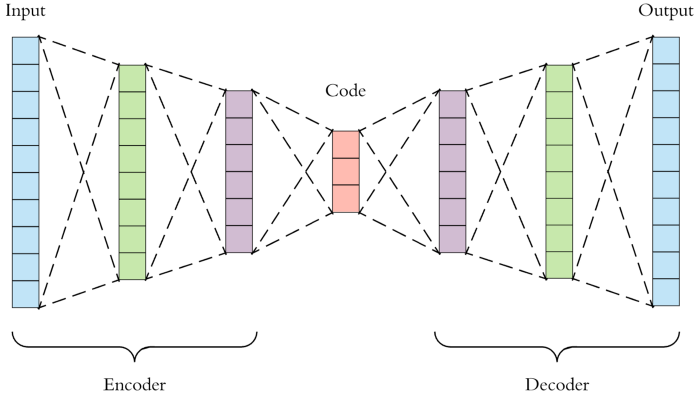

Autokoder składa się z dwóch części: kodera i dekodera. Pierwszy modyfikuje oryginalne dane, zazwyczaj je kompresując, naomiast koder dekoduje dane do oryginalnej postaci. Nie specyfikujemy a priori sposobu kodowania, sieć neuronowa sama uczy się optymalnego sposobu, stąd nazwa "autoencoder". Najpopularniejszą metodą uczenia autokoderów jest użycie błędu średniokwadratowego:

$\mathrm{MSE} = \frac{1}{n}\sum_{\mathrm{i}}^n \left(x_i - \tilde{x_i}\right)^2$

Gdzie $x_i$ to dane wejściowe (np. wartości pikseli obrazka), $\tilde x_i$ dane wyjściowe, a takich danych jest n w próbce.

#### Autokodery mają kilka interesujących zastosowań:
1. Pozwalają na kompresję danych, jeżeli ich środkowa część, którą będę nazywał przestrzenią ukrytą, ma mniejszą wymiarowość niż warstwy wejściowa/wyjściowa. 
2. Można ich użyć do odszumiania danych.
3. Można ich użyć do szukania anomalii, czyli rodzajów danych nieobecnych podczas procesu uczenia.
4. Po pewnych modyfikacjach mozna je użyć do generowania nowych danych, np. twarzy.

W dzisiejszym notatniku zajmiemy się odszumianiem danych.

## Wczytanie i wstępna obróbka danych

In [ ]:
import sys, os
from termcolor import colored
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import *
from tensorflow import random
from tensorflow.keras.datasets import fashion_mnist
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve

### Ładujemy obrazki ubrań z Zalando (FASHION MNIST)

Zbiór obrazków ubrań jest dostępny bezpośrednio poprzez Kerasa i wczytuje się go identycznie jak zbiór ręcznie pisanych cyfr.

In [ ]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

print("Training data features:", X_train.shape)
print("Training data labels:", Y_train.shape)

print("Test data features:", X_test.shape)
print("Test data labels:", Y_test.shape)

Jeżeli powyżej dostałeś błąd ssl to spróbuj odkomentować i odpalić najpierw poniższa komórkę.

In [ ]:
# import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     # Legacy Python that doesn't verify HTTPS certificates by default
#     pass
# else:
#     # Handle target environment that doesn't support HTTPS verification
#     ssl._create_default_https_context = _create_unverified_https_context


## Wstępne przygotowanie danych (ang. preprocessing)

Sieci ze splotem przyjmują na wejściu kolorowe obrazy. Kształt pojedynczego przykładu to: `(x pixels, y pixels, channels)`, gdzie:
- x, y pixels - liczba pikspeli w obu kierunkach
- channels - liczba kolorów, czyli "kanałów"

Dane które analizujemy mają postać dwuwymiarowych macierzy o kształcie `(x pixels, y pixels)`. Proszę:

* zmienić kształ danych wejścionych na `(x pixels, y pixels, channels)`. W naszym przypku mamy jeden kolor, czyli kanał. 
* wypisać kształ macierzy po spłaszeniu. Czy wymiar jest zgodny z oczekiwaniem?
* znormalizować wartości danych do zakresu **[0,1]** korzysatając z funkcji ```numpy.amax(...)```
* wybrać 1000 przykładów ze zbioru testowego

Oczekiwany rezultat to:

```
Training data shape before reshaping: (60000, 28, 28)
Training data shape after reshaping: (60000, 28, 28, 1)
Test data shape after selecting: (1000, 28, 28, 1)
Maximum value in training data: 255.0
```

**Wskazówka**: Nowy kształ macierzy można uzyskać dodając 1 do starego:
```
X_train.shape+(-1,)
```

Normalizujemy dane tak, żeby wartości pikseli były w przedziale [0,1]

In [ ]:
print("Training data shape before reshaping:",X_train.shape)

X_train = ...
X_test = ...
X_test = ...
Y_test = ...

print("Training data shape after reshaping:",X_train.shape)
print("Test data shape after selecting:",X_test.shape)

maxValue = ...
print("Maximum value in training data:",maxValue)

X_train = ...
X_test = ...

Wyświetlimy kilka pierwszych zdjęć wraz z etykietą klas.

In [ ]:
# definiujemy funkcję do wyświetlania obrazków, przyda się później
def plot(dataX, dataY):
    n = 4
    fig, axs = plt.subplots(n,n, figsize=(10,10)) 
    for ii in range(n*n):
        axs[ii//n, ii%n].imshow(dataX[ii], cmap='gray')
        axs[ii//n, ii%n].title.set_text('Klasa: {}'.format(dataY[ii]))
        plt.tight_layout()
    plt.show()

In [ ]:
plot(...)

## Budujemy sieć

Poprzez zmienną będziemy regulować rozmiar (wymiar) przetrzeni ukrytej (ang. latent space)

In [ ]:
latent_dim = 2

Poniższa klasa definiuje model typu `autoencoder`. Robi to tworząc koder i dekoder w momencie uruchomienia, a w momencie wywołania najpierw koduje, a później dekoduje dane. 

#### Uzupełnij fragmenty kodu i zdefiniuj w nich koder, który składa się z następujących warstw:
1. Warstwa wejściowa na obrazki
2. Warstwa konwolucyjna, 64 filtry 3x3, padding="same"
3. MaxPooling, 2x2, , strides=2, padding="valid"
4. Warstwa konwolucyjna, 64 filtry 3x3, padding="same"
5. MaxPooling, 2x2, , strides=2, padding="valid"
6. Warstwa spłaszczająca
7. Warstwa gęsta, 64 neurony
8. Warstwa gęsta, tyle neuronów co w latent_dim

Taka architektura sprawi, że przestrzenne wymiary obrazka będą maleć 2 razy po każdym poolingu.

#### Uzupełnij fragmenty kodu i zdefiniuj w nich dekoder, który składa się z następujących warstw:
1. Warstwa wejściowa odpowiadająca rozmiarowi przestrzeni ukrytej
2. Warstwa gęsta, 49 neuronów
3. Warstwa typu Reshape, nadaj danym wymiar 7x7x1
4. Warstwa konwolucyjna transponowana (`Conv2DTranspose`) 64 filtry 3x3, padding="same", strides=2
5. Warstwa konwolucyjna transponowana, 64 filtry 3x3, padding="same", strides=2
6. Warstwa konwolucyjna, 1 filtr 3x3, padding="same", funkcja aktywacyjna sigmoida

Najpierw nadajemy danym odpowiedni wymiar przestrzenny, później za pomocą wartsw konwolucyjnych transponowanych dwa razy zwiększamy wymiary dwukrotnie, czyli (7,7) -> (14,14) -> (28,28). Ostatnia warstwa konwolucyjna przywróci nam jeden kanał.

In [ ]:
# w tej klasie implementujemy nasz model
class Autoencoder(Model):
  def __init__(self):
    super(Autoencoder, self).__init__()
    
    # create encoder
    NN = Sequential()
    NN.add(layers.Input(shape=(28,28,1)))
    NN.add(...)
    NN.add(...)
    NN.add(...)
    NN.add(...)
    NN.add(...)
    NN.add(...)
    NN.add(...)
    # set up field
    self.encoder = NN
    
    # create decoder
    NN = Sequential()
    NN.add(layers.Input(shape=(latent_dim,)))
    NN.add(...)
    NN.add(layers.Reshape((7,7,1)))
    NN.add(...)
    NN.add(...)
    NN.add(...)
     # set up field
    self.decoder = NN

  def call(self, x):
    # use fields to create autoencoder
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

## Odszumianie zdjęć (denoising)

Dodamy teraz losowy szum do zdjęć i spróbujemy go usunąć za pomocą autoencodera.

Proszę:

* stworzyć zmienne  `X_train_noisy` oraz `X_train_noisy` w której do każdego piksela rysunku zostanie dodana liczba z rozkłądu normalnego pomnożona przez współczynnik `noise_factor`
* proszę przyjąć `noise_factor = 0.15`

In [ ]:
# zaszumimy nasze obrazki szumem Gaussowskim
noise_factor = 0.15
X_train_noisy = X_train + ...
X_test_noisy = X_test + ...

Proszę:
* wyświetlić zdjęcia z zaszumionego zbioru uczącego.

In [ ]:
plot(...)

### Konstrukcja modelu

Proszę:

* stworzyć zmienną `autoencoder` klasy `Autoencoder`
* wywołać metodę `compile(...)` ustawiając:
    * algorytm optymalizacji na `adam`
    * funkcją straty `mean_squared_error`
    


* wypisać na ekran opis modelu ```model.summary(...)```
* obejrzeć rysunek przedstawiający architekturę modelu, uzyskany przy pomocy funkcji ```tf.keras.utils.plot_model(...)```    

In [ ]:
latent_dim = 2
autoencoder = ...
autoencoder....
autoencoder.build(input_shape=X_train_noisy.shape)

autoencoder.summary()
tf.keras.utils.plot_model(autoencoder, 'ML_model.png', show_shapes=True)

## Trenowanie modelu

Proszę:

* przeprowadzić trening dla `10` epok z rozmiarem paczki wynoszącym `64`

**Uwaga**: Co należy podać jako docelowe wartości (tam gdzie do tej pory był podawane etykiety)?

**Uwaga**: proszę pełączyć śrdowisko wykonawcze by używało karty graficznej "GPU": z menu na górze:
```
Środowisko wykonawcze -> Zmień typ środowiska wykonawczego
```
Oczekiwany efekt:
```
Epoch 1/10
329/329 [==============================] - 5s 13ms/step - loss: 0.0662 - val_loss: 0.0470
Epoch 2/10
329/329 [==============================] - 4s 14ms/step - loss: 0.0442 - val_loss: 0.0445
```

Proszę:
* porównać wartości metryki na danych uczących i walidacyjnych. Jaki wniosek wynika z tego porównania?

**Wskazówka**: w czasie treningu proszę użyć parametru ```validation_split=0.3``` by uzyskać automatyczny podział danych uczących na uczące i walidacyjne.

In [ ]:
%%time

autoencoder_fit_history = autoencoder.fit(...)

## Analiza historii treningu

Proszę uzupełnić funkcję ```plotTrainingHistory(model_fit_history)``` tak by tworzyła wykres wartości metryki uczących i walidacyjnych

Wartości potrzebnych parametrów są dostępne w obiekcie ```Model.history```

In [ ]:
def plotTrainingHistory(model_fit_history):

    fig, axes= plt.subplots(1,1,figsize=(10,5))
    history = model_fit_history.history
    axes.plot(...)
    axes.plot(...)
    axes.set_ylabel('loss')
    axes.set_xlabel('epoch')
    axes.legend(['train', 'validation'], loc='upper left')
   
plotTrainingHistory(autoencoder_fit_history) 

### Sprawdzenie działania modelu na zbiorze testowym.

Proszę:
* zakodować rysunki ze zbioru tesowego używając pola `encoder` klasy `autoencoder`
* odkodować zakodowane rysunki używając pola `decoder` klasy `autoencoder`
* wykonać obie operacje w jednej linii używając operatora `()` klasy `autoencoder`

In [ ]:
# kodowanie danych do przestrzeni ukrytej
encoded_imgs = ...

# dekodowanie z przestrzeni ukrytej do postaci rysunku
decoded_imgs = ...

# kodowanie i dekodowanie w jednej linii
decoded_imgs = ...

### Wyświetlanie rysunków.

Proszę:

* wywołać poniższą funkcję jako argumenty podając dane zaszumione, oraz przeprowadzone przez procedurę kodowanie->odkodowanie
* wywołać poniższą funkcję jako argumenty podając oryginalne dane, oraz przeprowadzone przez procedurę kodowanie->odkodowanie

In [ ]:
def compare(data_pre, data_post):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original + noise
        ax = plt.subplot(2, n, i + 1)
        plt.title("original")
        plt.imshow(tf.squeeze(data_pre[i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        # display reconstruction
        bx = plt.subplot(2, n, i + n + 1)
        plt.title("reconstructed")
        plt.imshow(tf.squeeze(data_post[i]))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
    plt.show()

In [ ]:
compare(...)
compare(...)

* co można powiedzieć o działaniu autodekodera? 
* jak można zmodyfikować model by poprawić wyniki?
* jak ilościowo można oszacować zgodnośc odkodowanych rysunków z oryginalnymi?

**Odpowiedzi:**
* ...
* ...
* ...

### Rozkład średniego błedu kwadratowego (MSE)

* proszę dokończyć funkcję `plotMSE(model)` która rysuje średni błąd kwadratowy dla każdej klasy osobno
* proszę przeanalizować kod funkcji i odpowiedzieć na pytanie jak dokładnie jest obliczony MSE

In [ ]:
def plotMSE(model, X_Test, Y_test):
    plt.figure(figsize=(7, 7))
    for class_number in range(0,10):
        index = Y_test == class_number
        original = ...
        reconstructed = ...
        mse = tf.math.reduce_mean(..., axis=(1,2,3))
        plt.hist(mse.numpy(), bins=15, alpha=0.3, label=f'{class_number}')    
    plt.legend(ncol=2)
    plt.xlabel('MSE')   
    
plotMSE(autoencoder, X_test, Y_test)    

### Analiza średniego błędu kwadratowego (MSE)

* czy jakaś klasa wykazuje większe niż inne wartości MSE?
* korzystając z funkcji `compare(...)` proszę narysować przykłady dla klasy odstającej

In [ ]:
index = Y_test == 8

decoded_imgs = ...

compare(...)
compare(...)

### Analiza przestrzeni ukrytej
Proszę:

* uzupełnć funkcję `plotHiddenSpace(model, X_test, Y_test)` która rysuje współrzędne rysunków w przestrzeni ukrytej 
* czy można zidentyfikować obszary przestrzeni ukrytej odpowiedającej konkretnym klasom?

In [ ]:
def plotHiddenSpace(model, X_test, Y_test):
    encoded_imgs = ...
    xx = encoded_imgs[:, 0]
    yy = encoded_imgs[:, 1]
    zz = Y_test
    
    #fig, axes= plt.subplots(1,2,figsize=(15,7))
    plt.figure(figsize=(8, 7))
    plt.scatter(xx, yy, c=zz, cmap='tab10')
    plt.xlabel('$x_{1}$', fontsize=18)
    plt.ylabel('$x_{2}$', fontsize=18)
    plt.title('Wizualizacja przestrzeni ukrytej', fontsize=18)
    plt.colorbar()
    
    
    
plotHiddenSpace(...)   

### Korzystając z wizualizacji przestrzeni ukrytej proszę wygenerować 10 rysunków przedstawiających wybraną klasę

* proszę wygenerować 10 par stanowiących współrzędne w przestrzeni ukrytej w odpowiedniem obszarze
* użyć dekodera do wygenerowania rysunków
* użyć funkcji `compare(...)` do narysowania uzyskanych rysunków

In [ ]:
#losowanie współrzędnym w przestrzeni ukrytej
z1 = ...
z2 = ...
z = np.stack( (z1,z2), axis=1)

# dekodowanie rysunków ze współrzędnych w przestrzeni ukrytej
decoded_imgs = ...

# rysowanie odkodowanych rysunków
compare(...)

## Wykrywanie anomalii

Spróbujemy teraz użyć autokodera do wykrywania anomalii. Na początek anomalią będzie klasa 8 (torby). Wytrenujemy Autoencoder na obrazkach z pozostałych klas, a następnie sprawdzimy jego działanie na zbiorze testowym. Spodziewamy się, że sieć nauczy się rekonstruować poprawnie obrazki "normalnych" klas, a znacznie gorzej będzie radzić sobie z nieznanymi obiektami klasy nr 8. Czyli wartość błędu średniokwadratowego powinna być wyższa dla klasy anomalnej. Możemy zatem stworzyć klasyfikator binarny wykorzystujący MSE, który pozwoli nam rozpoznać obrazki niepodobne do niczego co sieć widziała w trakcie uczenia -- wykrywacz anomalii. Opisany sposób uczenia sieci nazywa się uczeniem z częściowym nadzorem (semi-supervised), ponieważ wiemy, że w zbiorze uczącym nie ma anomalii. Uczenie bez nadzoru zakładałoby możliwą niewielką obecność anomalii w zbiorze uczącym.

Proszę:

* usunąć z danych uczących wszystkie obrazki z klasy `8` 
* stworzyć i skompilować obiekt `anomaly_detector` klasy `Autoencoder`
* wytrenować model na danych pozbawionych klasy `8`
* narysować wykres wartości metryki w funkcji numeru epoki

In [ ]:
anomaly_class=8

# usuń anomalie z danych uczących
X_train_new = ...

# wytrenuj model używając tym razem tych samych danych na wejściu i wyjściu
anomaly_detector = ...
anomaly_detector....
anomaly_detector.build(input_shape=X_train_noisy.shape)

anomaly_detector_fit_history = anomaly_detector.fit(...)
plotTrainingHistory(...) 

Proszę:

* użyć obiektu `anomaly_detector` do zakodowania i odkodowania obrazków ze zbioru testowego
* znaleźć indeks pierwszego rusynku z klasy `8` w zbiorze testowym
* narysować zbiór oryginalnych i przetworzonych rysunków używająć przykładów ze zbioru testowego począwszy od indeksu rysunku z torbą

In [ ]:
bag_image_index = ...
print(colored("First bag image index:","blue"),bag_image_index)

decoded_imgs = anomaly_detector(...)
compare(...)

#### Dlaczego obrazek torby został zrekonstruowany gorzej niż inne?

### Analiza modelu

Proszę:

* narysować rozkład danych testowych w przestrzeni ukrytej
* rozkład średniego błędu kwadratowego

Czy na podstawie tych rysunków można podać kryteria identyfikacji przypadków anomalii (klasa 8)? 

In [ ]:
plotHiddenSpace(...) 
plotMSE(...) 

### Klasyfikacja anomalii i metryki modelu

Proszę:

* użyć wartości MSE jako zmiennej dyskryminującej: jest/nie ma anomalii
* narysować krzywą ROC dla takiego klasyfikatora
* dokończyć funkcję `plotMetric(model, X_test, labels)` rysującą: 
    * krzywą ROC dla modelu 
    * krzywą precyzji vs TPR

In [ ]:
def plotMetrics(model, X_test, labels):
    original = ...
    reconstructed = ...
    mse = ...
    fpr, tpr, thr = roc_curve(labels, mse)
    roc_auc = auc(fpr, tpr)
    
    ppv, rec, thr = precision_recall_curve(labels, mse)

    fig, axes= plt.subplots(1,2,figsize=(10,5))
    
    axes[0].plot(fpr, fpr, label='random model')
    axes[0].plot(fpr, tpr, label='anomaly detector, AUC={:0.3f}'.format(roc_auc))
    axes[0].set_xlabel('False positive rate')
    axes[0].set_ylabel('True positive rate')
    axes[0].set_title('ROC curve')
    axes[0].legend()
    
    anomalyFraction = 0.1
    axes[1].plot([0,1],[anomalyFraction, anomalyFraction], label='random')
    axes[1].plot(rec, ppv, label='anomaly detector')
    axes[1].set_xlabel('True Positive Rate')
    axes[1].set_ylabel('Recall')
    axes[1].set_title('Precision vs TPR')
    axes[1].legend()

labels = ...
plotMetrics(anomaly_detector, X_test, labels)

* Która z dwóch krzywych lepiej oddaje skuteczność naszego klasyfikatora i dlaczego? 
* Jak możnaby poprawić jego działanie?
* Jak zostały zdefiniowane modele losowe dla obu rysunków?

### Modyfikacja modeli

Proszę:

* skonstruować model, dla którego nie będzie widać problemu z rekonstrukcją rysunków z torbą, a MSE będzie mniejsze niż 0.1
* narysować historię treningu
* narysować rozkład MSE
* narysować rysunki zaszumione i oryginalne

Czy nowy model lepiej rekonstruuje zaszumione rysunki?

In [ ]:
...
...
...

In [ ]:
decoded_imgs_better = autoencoder_better(X_test_noisy)
decoded_imgs = autoencoder(X_test_noisy)

print(colored("Original model:","blue"))
compare(X_test_noisy, decoded_imgs)
print(colored("Improved model:","blue"))      
compare(X_test_noisy, decoded_imgs_better)